In [1]:
import GPy
import os
import numpy as np
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
import sys
from numpy.linalg import inv
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '/Users/dananjayaliyanage/git/emulator-validation/src')
from configurations import load_design, transform_design
from bayes_mcmc import *
from emulator import *
from calculations_load import trimmed_model_data
from bins_and_cuts import *
#Chain, credible_interval

Using idf = 0 : Grad
SystemsInfo = 
{'Pb-Pb-2760': {'proj': 'Pb', 'targ': 'Pb', 'sqrts': 2760, 'main_design_file': 'production_designs/500pts/design_pts_Pb_Pb_2760_production/design_points_main_PbPb-2760.dat', 'main_range_file': 'production_designs/500pts/design_pts_Pb_Pb_2760_production/design_ranges_main_PbPb-2760.dat', 'validation_design_file': 'production_designs/500pts/design_pts_Pb_Pb_2760_production/design_points_validation_PbPb-2760.dat', 'validation_range_file': 'production_designs/500pts/design_pts_Pb_Pb_2760_production//design_ranges_validation_PbPb-2760.dat', 'labels': ['$N$[$2.76$TeV]', '$p$', '$\\sigma_k$', '$w$ [fm]', '$d_{\\mathrm{min}}$ [fm]', '$\\tau_R$ [fm/$c$]', '$\\alpha$', '$T_{\\eta,\\mathrm{kink}}$ [GeV]', '$a_{\\eta,\\mathrm{low}}$ [GeV${}^{-1}$]', '$a_{\\eta,\\mathrm{high}}$ [GeV${}^{-1}$]', '$(\\eta/s)_{\\mathrm{kink}}$', '$(\\zeta/s)_{\\max}$', '$T_{\\zeta,c}$ [GeV]', '$w_{\\zeta}$ [GeV]', '$\\lambda_{\\zeta}$', '$b_{\\pi}$', '$T_{\\mathrm{sw}}$ [GeV]'], 'ma

 /Users/dananjayaliyanage/Downloads/enter/envs/hc/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning:sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.


In [2]:
name= ['norm','trento_p','sigma_k','nucleon_width','dmin3','tau_R','alpha','eta_over_s_T_kink','eta_over_s_low_T_slope',
      'eta_over_s_high_T_slope','eta_over_s_kink','zeta_over_s_max','zeta_over_s_T_peak','zeta_over_s_width','zeta_over_s_lambda_asymm'
      ,'shear_relax_time_factor','Tswitch','extra_cov_uncertinitiy']

In [3]:
MAP_params = {
                            'Pb-Pb-2760': [14.128, 0.089, 1.054, 1.064, 4.227, 1.507, 0.113, 0.223, -1.585, 0.32, 0.056, 0.11, 0.16, 0.093, -0.084, 4.666, 0.136],
                            'Au-Au-200' : [5.821, 0.089, 1.054, 1.064, 4.227, 1.507, 0.113, 0.223, -1.585, 0.32, 0.056, 0.11, 0.16, 0.093, -0.084, 4.666, 0.136]
                }

In [4]:
map_values=np.array(MAP_params["Pb-Pb-2760"])

In [5]:
MAP=transform_design(map_values.reshape(1,-1))

In [6]:
em=Trained_Emulators['Pb-Pb-2760']

In [7]:
# Get all the observables list
nobs=0
observables=[]
for obs, cent_list in obs_cent_list['Pb-Pb-2760'].items():
    observables.append(obs)
    n = np.array(cent_list).shape[0]
    #self._slices[obs] = slice(self.nobs, self.nobs + n)
    nobs += n

In [8]:
# Get the simulation results corresponding to design points
Y=[]
for ipt, data in enumerate(trimmed_model_data['Pb-Pb-2760']):
    row = np.array([])
    for obs in observables:
        values = np.array(data[idf][obs]['mean'])
        if np.isnan(values).sum() > 0:
            print("WARNING! FOUND NAN IN MODEL DATA WHILE BUILDING EMULATOR!")
            print("Design pt = " + str(pt) + "; Obs = " + obs)
        row = np.append(row, values)
    Y.append(row)
Y = np.array(Y)
print("Y_Obs shape[Ndesign, Nobs] = " + str(Y.shape))
pca = PCA(copy=False, whiten=True, svd_solver='full')
Z=pca.fit_transform(X=Y)[:,:10]

Y_Obs shape[Ndesign, Nobs] = (485, 123)


In [9]:
# Get design parametrs
design, design_max, design_min, labels = prepare_emu_design('Pb-Pb-2760')


Loading main points from production_designs/500pts/design_pts_Pb_Pb_2760_production/design_points_main_PbPb-2760.dat
Loading main ranges from production_designs/500pts/design_pts_Pb_Pb_2760_production/design_ranges_main_PbPb-2760.dat
Summary of design : 
Note : Transforming design of viscosities


In [10]:
if len(delete_design_pts_set) > 0:
    print("Warning! Deleting " + str(len(delete_design_pts_set)) + " points from data")
    design = np.delete(design, list(delete_design_pts_set), 0)

Warning! Deleting 15 points from data


In [11]:
design_max

array([19.99392   ,  0.69725   ,  1.99953   ,  1.49904   ,  4.9121    ,
        1.9982    ,  0.29887   ,  7.99819   ,  0.16496   ,  0.48579691,
        0.42717744,  0.36855797,  0.32421837,  0.37560888,  0.43243489,
        0.48926091,  0.54608692,  0.60291293,  0.65973894,  0.19417791,
        0.19618334,  0.19660374,  0.1988944 ,  0.19839818,  0.19292011,
        0.18976884,  0.17759692,  0.16433303,  0.15088399])

In [12]:
L=np.array(design[:,3])

In [13]:
# a function that takes Scikit lern emulator as input and return the corresponding GPy emulator.
def convertToGPy(Scikit_emu,design,pca_observable):
    """Takes a scikitlearn gaussian emulator as input and conver it to a GPy gaussian emulator. This needs
    design space parameters and the corresponding pca observable (PCA 1, PCA 2 etc)"""
    dic=Scikit_emu.get_params()
    kernel = GPy.kern.RBF(input_dim=29, variance=1., lengthscale=dic["kernel__k1__k2"].get_params()["length_scale"],ARD=True)
    m = GPy.models.GPRegression(design,pca_observable,kernel,noise_var=dic["kernel__k2__noise_level"])
    #m.constrain_positive('') 
   # m.optimize_restarts(num_restarts = 1)
    return m
    

In [14]:
#make an dictionary of GPy emulators corresponding to each of the 10 PCA components of the observables
GPy_emulators={}
for i in range(0,10):
    EM=em.gps[i]
    zz=Z.T[i].reshape(-1,1)
    GPy_emulators[i]=convertToGPy(Scikit_emu=EM,design=design,pca_observable=zz)
    

In [15]:
## get a design matrix of only one parameter varying
def getDesignMatrix(param,MAP_parameter_Values):
    """get a design matrix of 300 uniformly distibuted points with only one parameter varying.
    All the other parameters are in the MAP values. return matrix dimension (300,29)"""
    x_eta=np.linspace(design_min[param],design_max[param],300) # get 300 x axis values for the plot
    LL=np.zeros((300,29))
    x=transform_design(MAP_parameter_Values.reshape(1,-1))
   # print(x)
    for i,j in enumerate(x_eta):
        #print(j)
        np.put(x,param,j)
       # x[param]=j
       # print(x)
       # print(j)
        LL[i,:]=x
    return LL,x_eta

In [16]:
#Write a function that will take one of the 10 GPy emulators and plot how the corresponding PCA value change
#with each parameter in the model keeping all the other parameters fixed at MAP values.... produce 29 graphs ....

def PCAgraphs(PCA_number,GPy_array):
    m = GPy_array[PCA_number]
    for k in range(0,29):
        LL,x_predict=getDesignMatrix(k,np.array(MAP_params["Pb-Pb-2760"]))
        mean_grad,var_grad=m.predict_jacobian(Xnew=LL)
        y_predict,var_predict=m.predict(Xnew=LL)
        # only get the diagonal and the relevent mean for changing model parameter
        #diagonal=np.zeros((300,1))
       # mean=np.zeros((300,1))
        diagonal=[]
        mean=[]
        #y_predict=np.zeros((300,1))
        #sigma_predict=np.zeros((300,1))
        for ii in range(0,300):
            cov=var_grad[ii]
           # print(cov.diagonal())
            diagonal.append(cov.diagonal()[k])
            mean.append(mean_grad[ii][k])
        #    sigma_predict[i]=ysigma_predict.diagonal()[2]
        #y_predict=y_predict
        #print(var_predict)
        sigma_grad=np.sqrt(diagonal)
        mean_grad=np.array(mean)
        sigma_predict=np.sqrt(var_predict)
        # Plot the function, the prediction and the 95% confidence interval based on
        # the MSE
        %matplotlib inline
        plt.figure(figsize=(7,7))
       #plt.plot(x_true,y_true, 'b-', label=r'$f(x) = x sin(x)$')
        plt.plot(design[:,k],Z.T[PCA_number], 'r.', markersize=10, label='simulation data')
        plt.plot(x_predict.flatten(), y_predict.flatten(), 'r', label='Prediction from GP emulator')
        plt.fill_between(x_predict.flatten(),y_predict.flatten() - 1.9600 * sigma_predict.flatten(),y_predict.flatten() + 1.9600 * sigma_predict.flatten(), alpha=.5, fc='c', ec='None')
        plt.xlabel(f'model_param_{k}')
        plt.ylabel(f'PCA component {PCA_number}')
        #plt.plot(x_true,f_grad(x_true), 'g', label=r'$f(x) = xcos(x) + sin(x)$')
        plt.plot(x_predict.flatten(), mean_grad.flatten(), 'k', label='Gradiant prediction')
        plt.fill_between(x_predict.flatten(),mean_grad.flatten() - 1.9600 * sigma_grad.flatten(),mean_grad.flatten() + 1.9600 * sigma_grad.flatten(), alpha=.5, fc='y', ec='None')
        plt.title('Gradiant of the gaussian process found by Gpy')
        plt.tight_layout()
        plt.legend(loc='lower left')
        plt.savefig(f'/Users/dananjayaliyanage/git/emulator-validation/graphs/emulator_gradients/emu{PCA_number}param{k}.png',dpi=100)
        plt.show()

# The huge variance for gradients is a result of having very small corelation lengths in the optimized Gaussian emulator

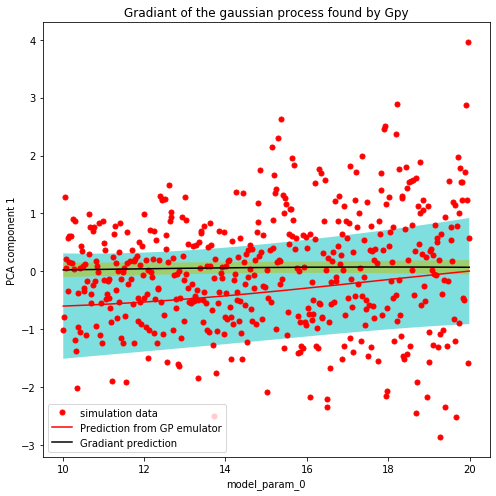

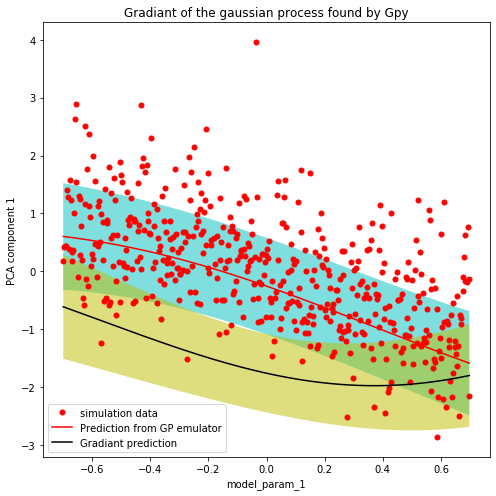

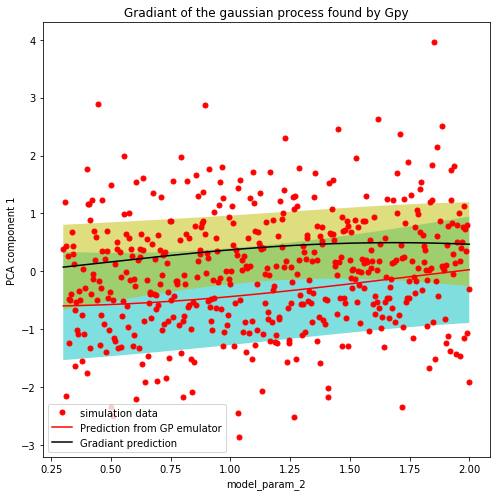

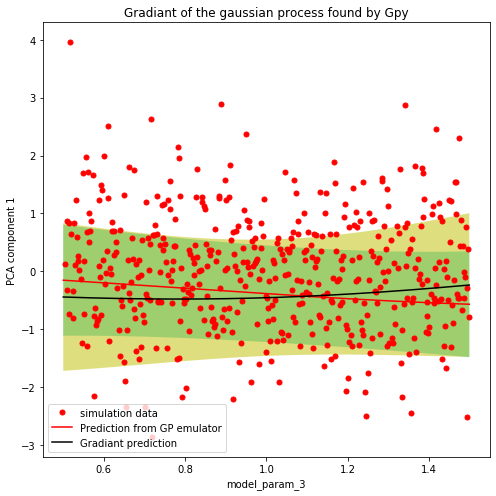

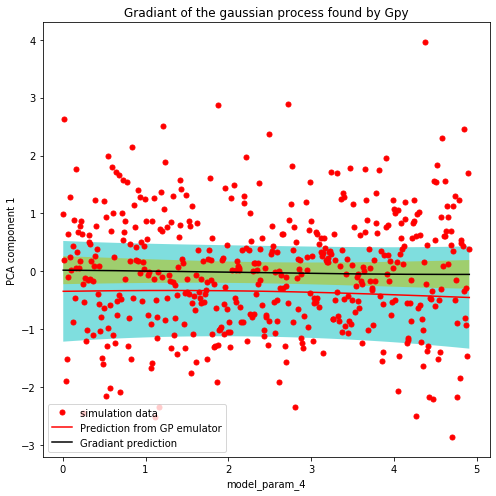

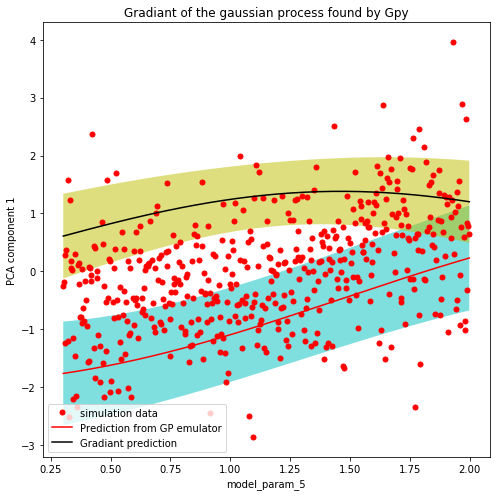

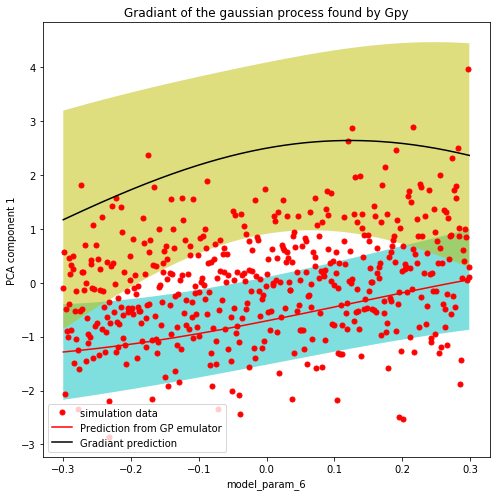

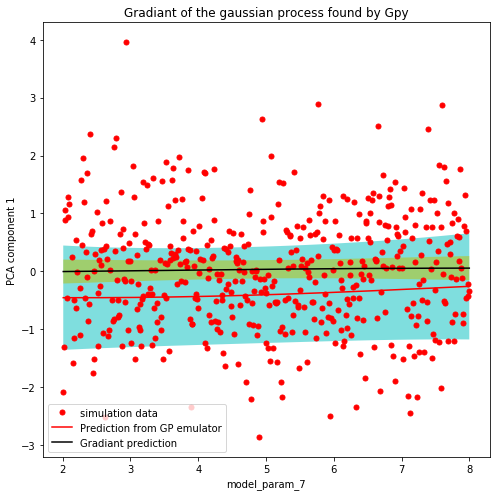

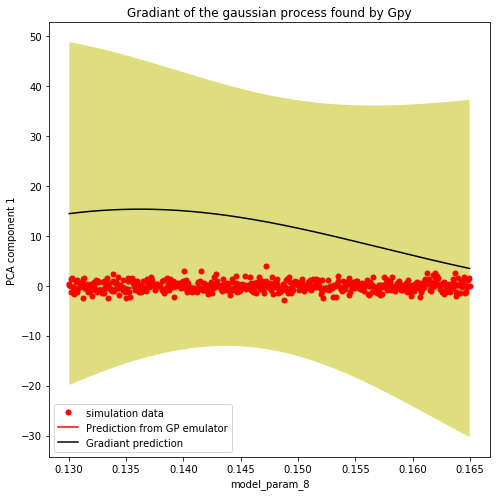

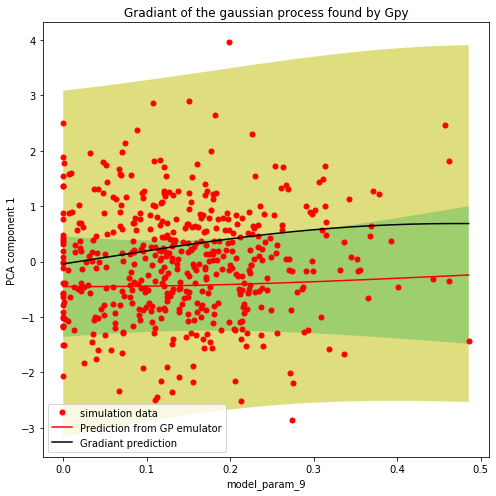

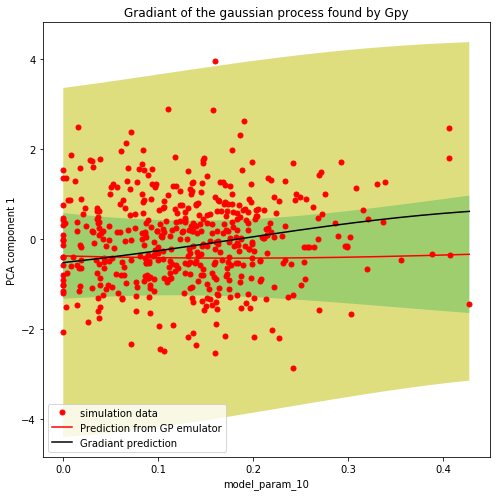

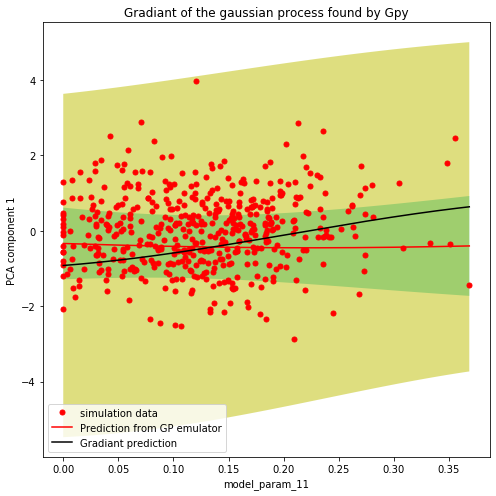

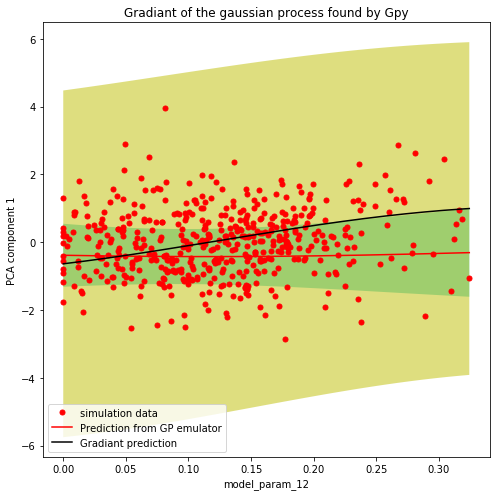

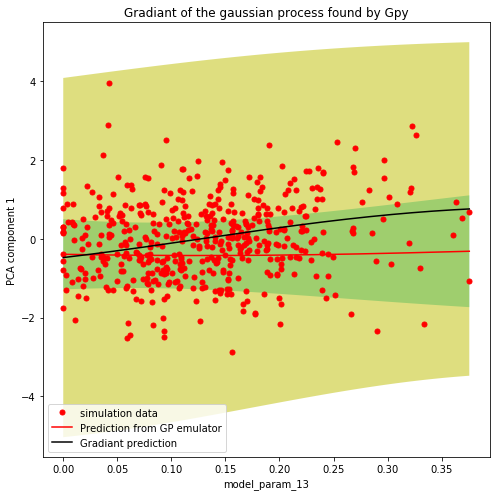

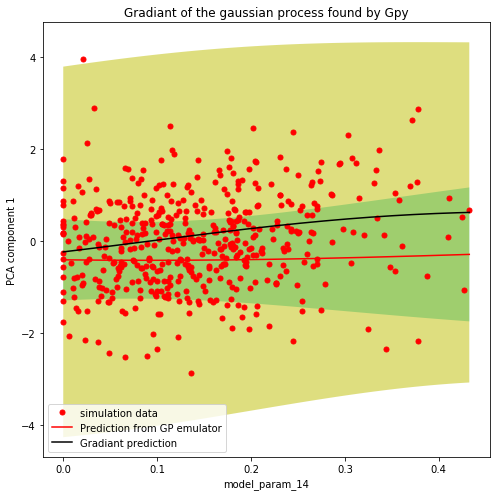

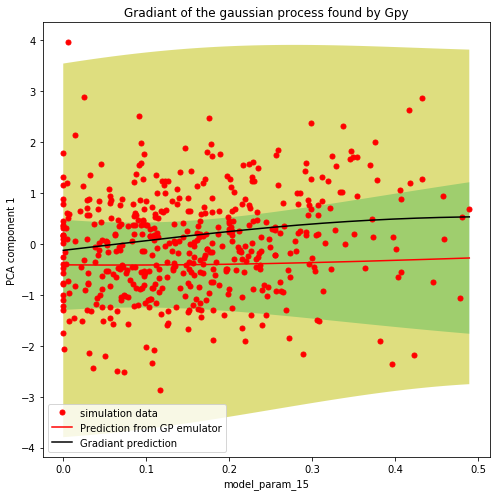

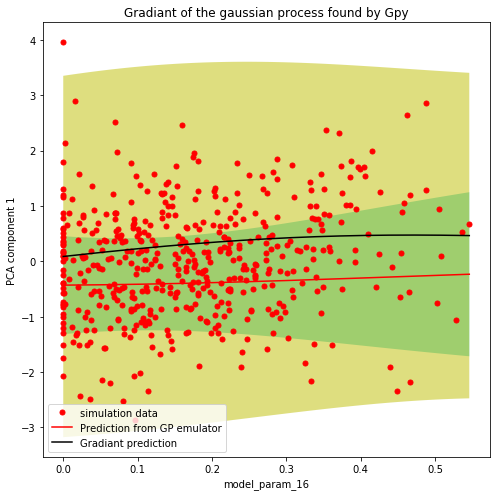

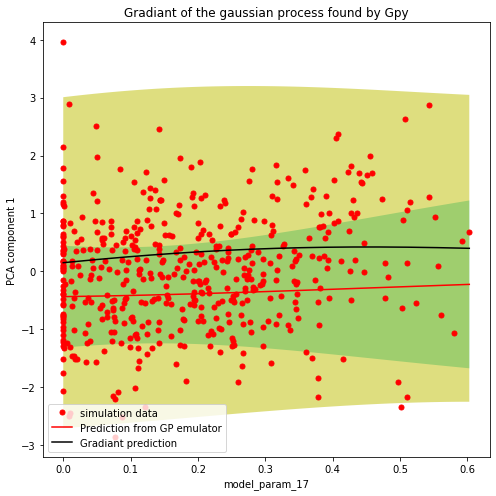

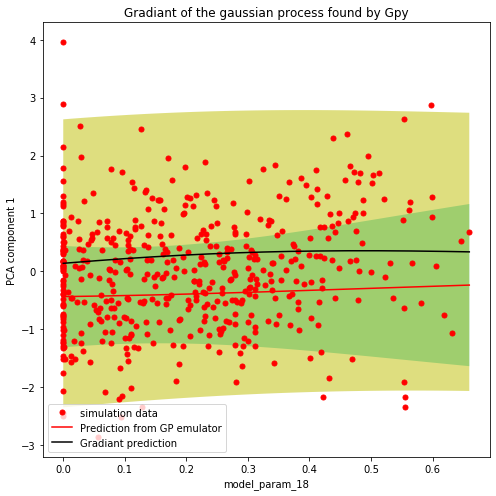

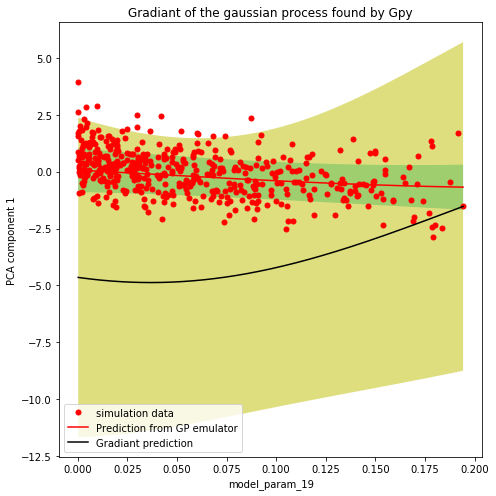

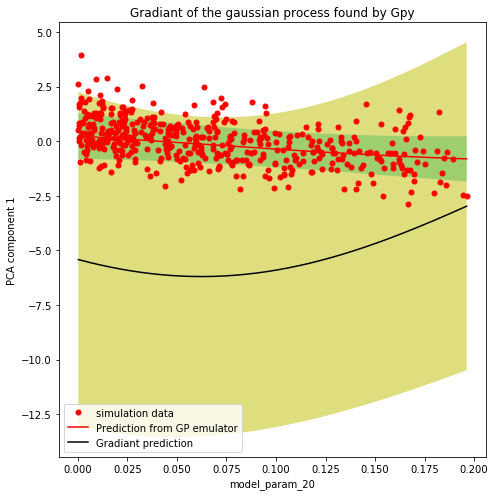

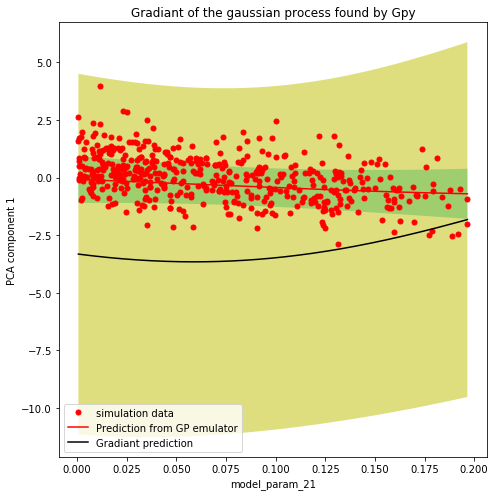

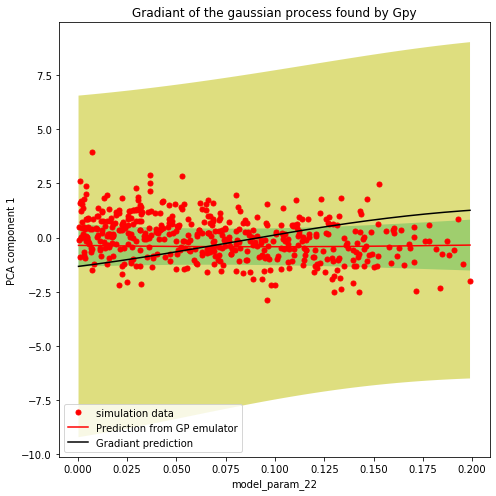

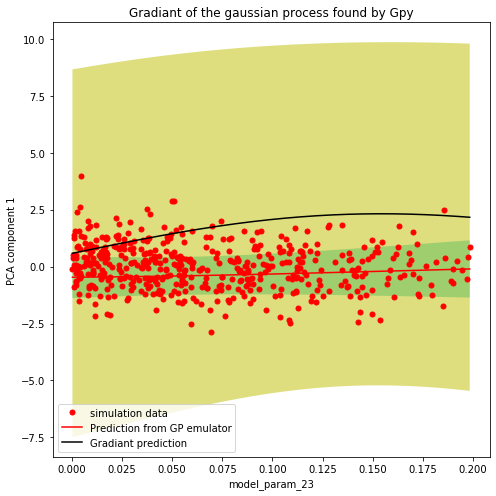

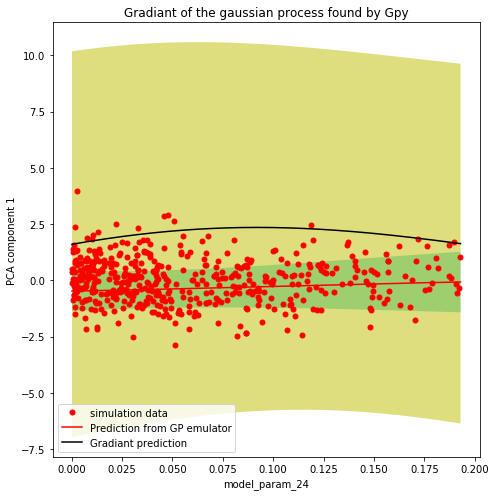

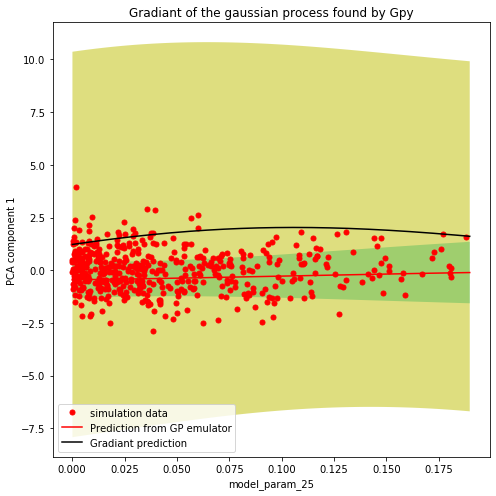

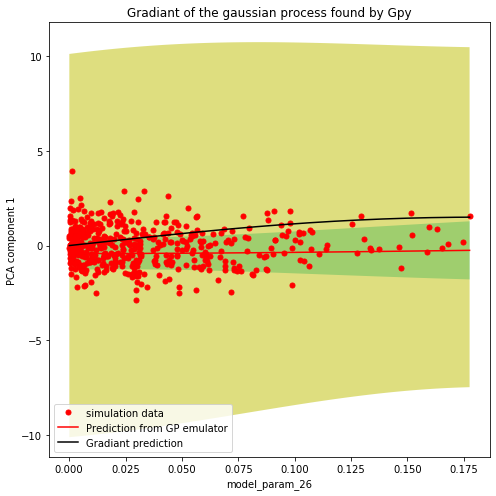

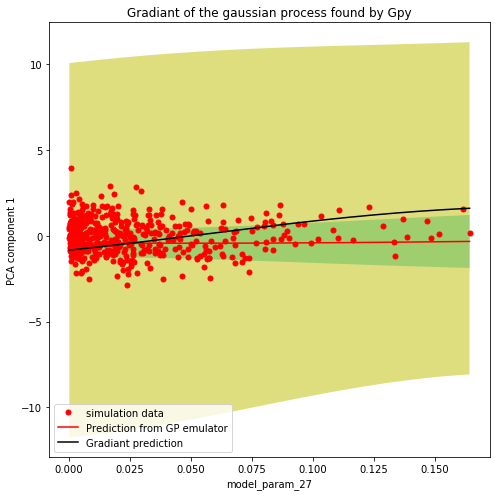

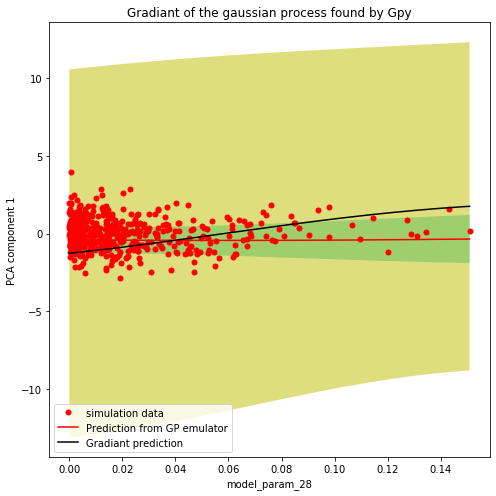

In [17]:
PCAgraphs(1,GPy_emulators)

In [18]:
em.gps[0].get_params()["kernel__k1__k2"]

RBF(length_scale=[9.98, 1.4, 1.7, 0.999, 4.91, 1.7, 0.598, 5.99, 0.0349, 0.486, 0.427, 0.369, 0.324, 0.376, 0.432, 0.489, 0.546, 0.603, 0.66, 0.194, 0.196, 0.196, 0.198, 0.198, 0.193, 0.19, 0.178, 0.164, 0.151])

In [19]:
grad_arry=np.ones((29,10))
sigma_arry=np.ones((29,10))
for k in range(0,10):
        m=GPy_emulators[k]
        grad,var_grad=m.predict_jacobian(Xnew=MAP.reshape(1,29))
        grad_arry[:,k]=grad.reshape(29,)
        l=0
        for i in var_grad.diagonal():
            if i<0:
                l=l+1
        print(f'pca is {k} with {l} negatives')
        sigma=np.sqrt(np.array(abs(var_grad.diagonal())))
        sigma_arry[:,k]=sigma.reshape(29,)

pca is 0 with 14 negatives
pca is 1 with 14 negatives
pca is 2 with 14 negatives
pca is 3 with 14 negatives
pca is 4 with 14 negatives
pca is 5 with 14 negatives
pca is 6 with 14 negatives
pca is 7 with 14 negatives
pca is 8 with 14 negatives
pca is 9 with 14 negatives


In [20]:
dicc=em._inverse_transform(grad_arry[2,:])

In [21]:
grad_arry[2,:]

array([-1.33382604e-01,  3.89834944e-01,  9.05798421e-04,  3.32300778e-01,
       -1.29745933e-01,  4.39072821e-01,  1.17662459e+00, -9.07338392e-01,
       -5.97524557e-01, -9.33903906e-01])

In [78]:
a=[1,2,-3,-1]
np.log(a)

 /Users/dananjayaliyanage/Downloads/enter/envs/hc/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning:invalid value encountered in log


array([0.        , 0.69314718,        nan,        nan])

In [22]:
model_labels= ['norm','trento_p','sigma_k','nucleon_width','dmin3','tau_R','alpha','shear_relax_time_factor','Tswitch']

In [23]:
dicc

{'dNch_deta': array([1397.84735944, 1128.15545314,  848.99686243,  576.88427333,
         382.64589525,  242.29006537,  143.16681642,   76.60738385]),
 'dET_deta': array([1987.56993961, 1758.62978343, 1590.05633359, 1443.70218785,
        1313.34851541, 1194.66061024, 1084.69090224,  986.85763782,
         895.97449057,  812.20970776,  735.09614673,  662.14633351,
         596.80059544,  536.35566538,  478.90205904,  426.921241  ,
         356.99518602,  276.18486002,  209.46108898,  154.64249797,
         111.51200826,   77.5706463 ]),
 'dN_dy_pion': array([1278.19263671, 1030.04441045,  773.8512572 ,  525.22820873,
         348.53332885,  221.13108149,  131.10667397,   70.43481935]),
 'dN_dy_kaon': array([220.20614111, 178.42840923, 135.08899793,  92.46647046,
         61.87227167,  39.58309064,  23.68883462,  12.86605625]),
 'dN_dy_proton': array([69.4277871 , 57.0214207 , 43.85317194, 30.6858188 , 20.92156659,
        13.63579418,  8.32228448,  4.62093018]),
 'dN_dy_Lambda': array(

In [40]:
### Get the factors I have to multiply gradients with to make them dimensio #model parameter unit in the numerator. 
Map_model_param_for_dim=MAP.reshape(29,) 
MapObservabes=em._inverse_transform(Map_model_param_for_dim)


In [49]:
Map_model_param_for_dim

array([1.41280000e+01, 8.90000000e-02, 1.05400000e+00, 1.06400000e+00,
       4.22700000e+00, 1.50700000e+00, 1.13000000e-01, 4.66600000e+00,
       1.36000000e-01, 1.95480000e-01, 1.48810556e-01, 1.02141111e-01,
       5.61066667e-02, 6.55288889e-02, 7.49511111e-02, 8.43733333e-02,
       9.37955556e-02, 1.03217778e-01, 1.12640000e-01, 1.03627213e-01,
       1.09701400e-01, 9.49704400e-02, 7.08432682e-02, 5.03173029e-02,
       3.59657530e-02, 2.63805510e-02, 1.99277275e-02, 1.54731465e-02,
       1.23081479e-02])

In [91]:
#Function where we specefy the observable.
# we will get a plot as a result showing how sensitive this observable for all centrality to all model parameters
#at MAp parameters

def sensitivity_plot(observable_name):
    modelparam_Gradient=[]
    modelparam_Grad_sigma=[]
    for i in range(1,29):
        temp_dic_all_grad=em._inverse_transform(grad_arry[i,:])
       # print(grad_arry[i,:])
       # print(temp_dic_all_grad)
        temp_dic_all_var=em._inverse_transform(sigma_arry[i,:])
        modelparam_Gradient.append(temp_dic_all_grad[observable_name])
        modelparam_Grad_sigma.append(temp_dic_all_var[observable_name])
    centrality=obs_cent_list["Pb-Pb-2760"][observable_name]
    fig,axes=plt.subplots(nrows=len(centrality), ncols=1, sharex=False ,figsize=(10, 40))
    #fig,axes=plt.subplots(nrows=2, ncols=1, sharex=False ,figsize=(10, 10))

    X_values=np.array([i for i in range(1,29)])
    #print(X_values.shape)
    #X_values.reshape(29,)
    for j,ax in enumerate(axes):
        sensitivity_list=[grad_cent_arry[j] for grad_cent_arry in modelparam_Gradient]
        sensitivity_error=[grad_error_cent_arry[j] for grad_error_cent_arry in modelparam_Grad_sigma]
        #sensitivity_list=np.array(sensitivity_list)
        #sensitivity_error=np.array(sensitivity_error)
        sensitivity_list=np.log([abs(values*Map_model_param_for_dim[i]/MapObservabes[observable_name][j]) for i,values in enumerate(sensitivity_list)]).flatten()
       # sensitivity_error=np.array([(values*Map_model_param_for_dim[i]/MapObservabes[observable_name][j]) for i,values in enumerate(sensitivity_error)]).flatten()
       # print(sensitivity_list)
       # print("error")
       # print(sensitivity_error)
                                   
        #print(f'length of sens {sensitivity_list.shape} and length of error {sensitivity_error.shape}')
        #ax.plot(X_values,sensitivity_list)
        #print(sensitivity_list)
       # print("error next")
       # print(sensitivity_error)
        #ax.errorbar(X_values,sensitivity_list,yerr=sensitivity_error,fmt='o',ecolor='r')
        
        axes[0].scatter(X_values,sensitivity_list, marker='x' , alpha=0.5, size=4)
        
        axes[0].set_ylabel(observable_name)#+f'  {centrality[j]}',fontsize=14)
        axes[0].grid(b=True,axis='x')
        axes[0].set_xticks(X_values) 
    #plt.xticks(X_values,model_labels)
    plt.xlabel('Model parameters',fontsize=18)
    plt.xticks(rotation='vertical',fontsize=14)
   # plt.ylabel('Varied Observable',fontsize=18)
    plt.tight_layout()
    #plt.title("Gradients")
    plt.savefig(f'/Users/dananjayaliyanage/git/emulator-validation/graphs/sensitivity/sensitivity_{observable_name}.png',dpi=100)
    plt.show()

dNch_deta


AttributeError: 'PathCollection' object has no property 'size'

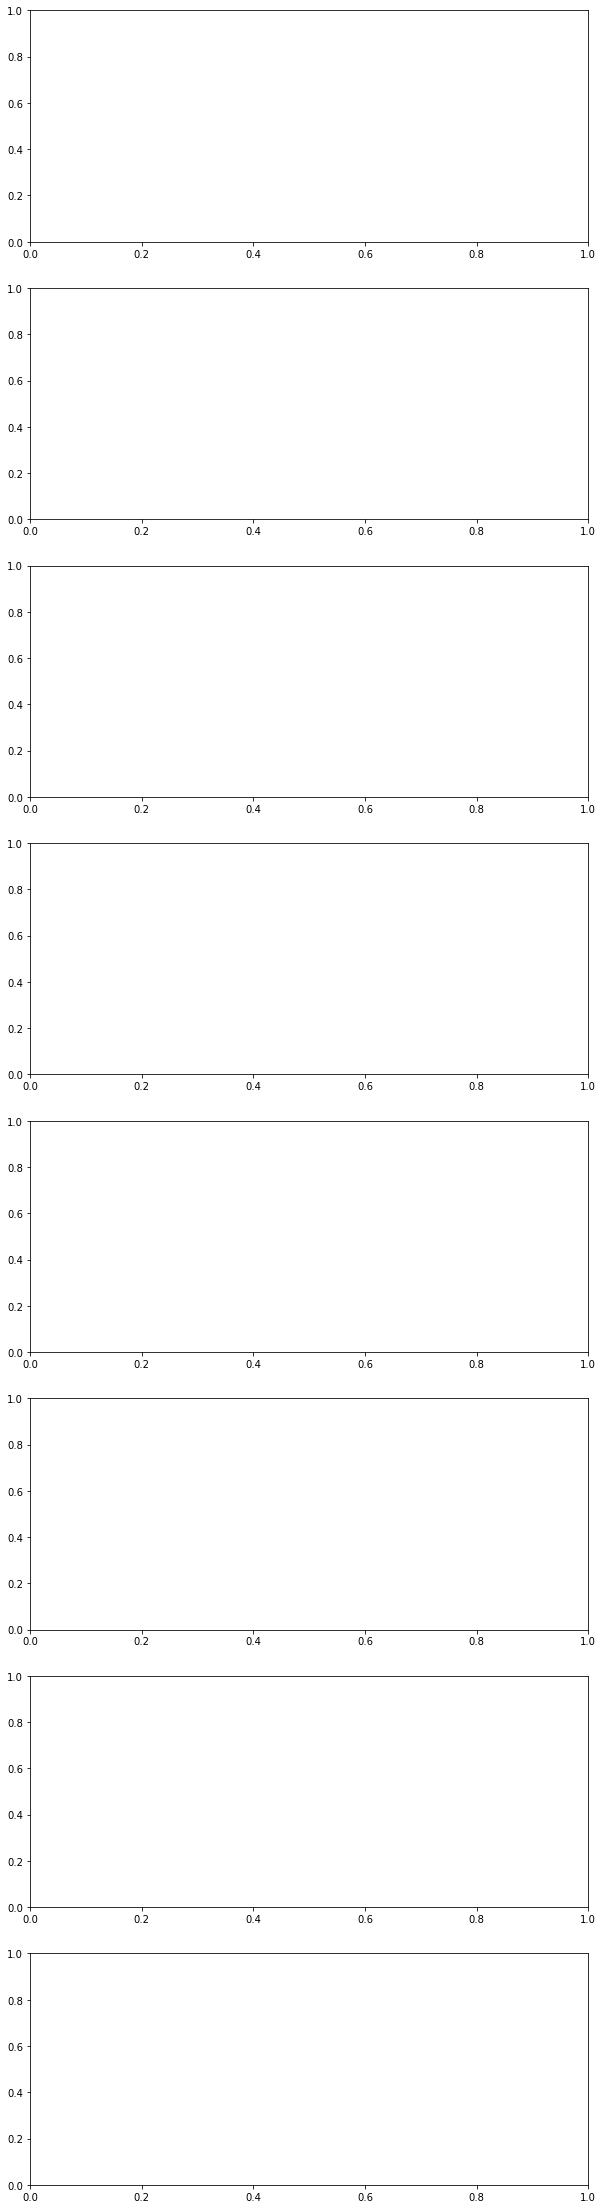

In [92]:
for i in dicc.keys():
    print(i)
    sensitivity_plot(observable_name=str(i))

# Ignore the code belwo this point for now


In [ ]:
#PCAgraphs(0,GPy_emulators)

In [ ]:
design_nt, design_max_nt, design_min_nt, labels_nt =load_design(system_str='Pb-Pb-2760', pset='main')
design_nt= np.delete(np.array(design_nt),list(delete_design_pts_set), 0)

In [ ]:
## get a design matrix of only one parameter varying
def getDesignMatrix_nt(param,MAP_parameter_Values):
    """get a design matrix of 300 uniformly distibuted points with only one parameter varying.
    All the other parameters are in the MAP values. return matrix dimension (300,29)"""
    x_eta=np.linspace(design_min_nt[param],design_max_nt[param],300) # get 300 x axis values for the plot
    LL=np.zeros((300,29))
    x=MAP_parameter_Values
   # print(x)
    for i,j in enumerate(x_eta):
        x[param]=j
        LL[i,:]=transform_design(x.reshape(1,-1))
    return LL,x_eta

In [ ]:
#Write a function that will take one of the 10 GPy emulators and plot how the corresponding PCA value change
#with each parameter in the model keeping all the other parameters fixed at MAP values.... produce 29 graphs ....

def PCAgraphnt(PCA_number,GPy_array):
    m = GPy_array[PCA_number]
    x_star=MAP.reshape(29,)
    for k in range(0,17):
        LL,x_predict=getDesignMatrix_nt(k,np.array(MAP_params["Pb-Pb-2760"]))   
        mean_grad,var_grad=m.predict_jacobian(Xnew=LL)
        y_predict,var_predict=m.predict(Xnew=LL)
        # only get the diagonal and the relevent mean for changing model parameter
        diagonal=np.zeros((300,1))
        mean=np.zeros((300,1))
        #y_predict=np.zeros((300,1))
        #sigma_predict=np.zeros((300,1))
        for ii in range(0,300):
            cov=var_grad[ii]
            diagonal[ii]=cov.diagonal()[k]
            mean[ii]=mean_grad[ii][k]
        #    sigma_predict[i]=ysigma_predict.diagonal()[2]
        #print(y_predict)
        #y_predict=y_predict
        sigma_grad=np.sqrt(diagonal)
        mean_grad=mean
        sigma_predict=np.sqrt(var_predict)
        # Plot the function, the prediction and the 95% confidence interval based on
        # the MSE
        %matplotlib inline
        plt.figure(figsize=(10,10))
       #plt.plot(x_true,y_true, 'b-', label=r'$f(x) = x sin(x)$')
        plt.plot(design_nt[:,k],Z.T[PCA_number], 'r.', markersize=10, label='simulation data')
        plt.plot(x_predict.flatten(), y_predict.flatten(), 'r', label='Prediction from GP emulator')
        plt.fill_between(x_predict.flatten(),y_predict.flatten() - 1.9600 * sigma_predict.flatten(),y_predict.flatten() + 1.9600 * sigma_predict.flatten(), alpha=.5, fc='c', ec='None')
        plt.xlabel(f'model {labels_nt[k]}')
        plt.ylabel(f'PCA component {PCA_number}')
        #plt.plot(x_true,f_grad(x_true), 'g', label=r'$f(x) = xcos(x) + sin(x)$')
        plt.plot(x_predict.flatten(), mean_grad.flatten(), 'k', label='Gradiant prediction')
        plt.fill_between(x_predict.flatten(),mean_grad.flatten() - 1.9600 * sigma_grad.flatten(),mean_grad.flatten() + 1.9600 * sigma_grad.flatten(), alpha=.5, fc='y', ec='None')
        plt.title('Gradiant of the gaussian process found by Gpy')
        plt.tight_layout()
        plt.legend(loc='lower left')
        plt.show()
        plt.savefig(f'/Users/dananjayaliyanage/git/emulator-validation/graphs/emulator_gradients/ntemu{PCA_number}param{k}.png',dpi=100)

In [ ]:
#PCAgraphnt(0,GPy_emulators)

In [ ]:
#PCAgraphnt(0,GPy_emulators)

In [ ]:
#x_star=np.random.uniform(design_min,design_max)

In [ ]:
np.array(MAP_params["Pb-Pb-2760"])

In [ ]:
LL2,x_predict=getDesignMatrix_nt(2,np.array(MAP_params["Pb-Pb-2760"])) 

In [ ]:
LL1.shape

In [ ]:
map_values=np.array(MAP_params["Pb-Pb-2760"])

In [ ]:
map_values

In [ ]:
LL1[1,:]

In [ ]:
#x_eta=np.random.uniform(design_min[2],design_max[2],300)
